Shakshi Singh Rajput

U21EC138

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.2686 - val_loss: 0.1554
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.1509 - val_loss: 0.1368
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.1355 - val_loss: 0.1287
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1280 - val_loss: 0.1244
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1231 - val_loss: 0.1217
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1197 - val_loss: 0.1189
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1175 - val_loss: 0.1170
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.1151 - val_loss: 0.1163
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.1135 - val_loss: 0.1140
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.1125 - val_loss: 0.1135
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.1109 - val_loss: 0.1136
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━

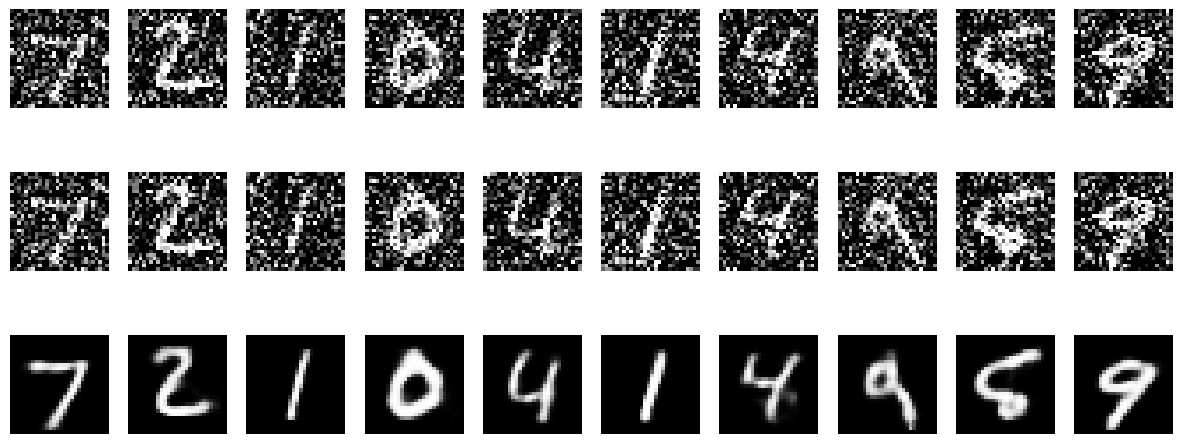

PSNR for Dense Autoencoder (3 Layers Each): 9.43
PSNR for PCA: 22.77


<ipython-input-4-1e38a1b41947>:95: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  return PSNR(original, denoised)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add Gaussian noise
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0.0, 1.0)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

from tensorflow.keras import layers, models

# Flatten images for dense layer processing
x_train_flat = x_train.reshape((len(x_train), 28 * 28))
x_test_flat = x_test.reshape((len(x_test), 28 * 28))
x_train_noisy_flat = x_train_noisy.reshape((len(x_train_noisy), 28 * 28))
x_test_noisy_flat = x_test_noisy.reshape((len(x_test_noisy), 28 * 28))

# Build dense autoencoder
input_img = layers.Input(shape=(28 * 28,))

# Encoder
encoded = layers.Dense(256, activation='relu')(input_img)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(28 * 28, activation='sigmoid')(decoded)

# Create autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Train the autoencoder on noisy images
autoencoder.fit(x_train_noisy_flat, x_train_flat,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy_flat, x_test_flat))


denoised_images_ae_flat = autoencoder.predict(x_test_noisy_flat)
denoised_images_ae = denoised_images_ae_flat.reshape(len(denoised_images_ae_flat), 28, 28)

from sklearn.decomposition import PCA

# Reshape images for PCA
x_test_flat = x_test_noisy.reshape(len(x_test_noisy), -1)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
x_test_pca = pca.fit_transform(x_test_flat)
x_test_pca = pca.inverse_transform(x_test_pca)
x_test_pca = x_test_pca.reshape(len(x_test_pca), 28, 28, 1)

def plot_images(original, noisy, denoised_ae, denoised_pca, num_images=10):
    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        # Original
        plt.subplot(3, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Noisy
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Denoised AE
        plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(denoised_ae[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()

# Plot the images
plot_images(x_test_flat.reshape(len(x_test), 28, 28), x_test_noisy.reshape(len(x_test_noisy), 28, 28),
            denoised_images_ae, x_test_pca)

# Evaluate performance (e.g., using PSNR)
from skimage.metrics import peak_signal_noise_ratio as PSNR

def calculate_psnr(original, denoised):
    return PSNR(original, denoised)

# Evaluate performance (PSNR)
psnr_ae = calculate_psnr(x_test_flat, denoised_images_ae_flat)
psnr_pca = calculate_psnr(x_test_flat, x_test_pca.reshape(len(x_test_pca), 28 * 28))

print(f'PSNR for Dense Autoencoder (3 Layers Each): {psnr_ae:.2f}')
print(f'PSNR for PCA: {psnr_pca:.2f}')


Conclusion

The Autoencoder (AE) outperformed PCA in denoising MNIST images, delivering sharper and more detailed reconstructions by capturing non-linear features. PCA, while faster and simpler, struggled with fine details and produced slightly blurred outputs. AE is more effective for complex noise patterns, whereas PCA is suitable for simpler tasks with limited resources.